In [1]:
import sqlite3
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import pickle
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

Reference(https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)
This LDA analysis is for 2020-2022 all records. 

In [2]:
textfile = open("stopwords_defined.txt", "r")
file_content = textfile.read()
stop_words = file_content.split("\n")

In [3]:
conn = sqlite3.connect('speech.db')

In [4]:
all = pd.read_sql_query(f'''SELECT * FROM speech WHERE speech_date >= '2020-01-01' AND speech_date <= '2022-12-31' ''', conn)
vectorizer = CountVectorizer(min_df=5, max_features=5000, stop_words=stop_words)
data_vectorized = vectorizer.fit_transform(all["speech"])
lda_model = LatentDirichletAllocation(n_components=6,
                            random_state=123,
                            learning_method='online',
                            n_jobs = -1)
lda_output = lda_model.fit_transform(data_vectorized)

In [5]:
filename = 'lda_model.sav'
pickle.dump(lda_model, open(filename, 'wb'))

In [6]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = all["speech"]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
speech,,,,,,,
質問 国会 建設業者 工事 受注 建設工事 受注 動態 統計 データ 書換え 問題 書換え GDP 値 過大 問題 前半 問題 統計データ 賃上げ 課題 お手元 資料 一月二十五日 朝日新聞 一面 統計 過大 記事 GDP 計算 材料 受注 統計 総額 元請 下請 受注 合算 数字 GDP 計算 材料 元請 受注 国交省 お答え,0.010000,0.010000,0.010000,0.900000,0.080000,0.010000,3
パネル 茨城 国光 議員 お願い 冒頭 問題 建設工事 受注 動態 統計 建設工事 発注 着工 完成 引渡し 工事 総額 注文 ベース 元請 受注 完成 ベース 元請 完成 工事 二つ アプローチ 国交省 二つ 統計 両者 工期 ずれ ベース 同額 推計 完成 工事 建設工事 施工 統計 サンプル 一年 調査 回収 受注 統計 正確 GDP 推計 施工 統計 GDP 推計 四半期 リアルタイム 一年 統計 一年 集計 一年 GDP 集計 GDP 集計 推計 受注 統計 受注 統計 回収 GDP 推計 調査 提出 大変 負担 回収 青 完成 赤 受注 統計 赤 工事 総額 材料 種類 統計 前々 受注 上下 受注 元請 下請 土木 建築 官公庁 受注 民間 受注 内訳 総務省 統計局 日本 統計 受注 統計 内訳 統計 伸び率 GDP 決算 ベース 建設 投資額 基 数字 決算 ベース 額 完成 工事 精緻 決算 ベース 建設 投資 受注 工事 受注 工事 伸び率 GDP 基 建設 投資 推計 作業 工事 幾ら 余り 統計 民間 業者 苦労 正確 数値 受注 国交省 検討 統計 一定 係数 階層 複雑 完成 工事 係数 検討 受注 統計 業者 調査 翌々月 処理 伸び率 影響 受注 統計 疑念 自民党 政権 復帰 大幅 補正 予算 受注 統計 伸び率 計算 建設 投資額 投資額 決算 ベース 伸び率 GDP 過大 疑念 野党 皆さん アベノミクス 成果 過大 国交省 説明,0.000000,0.010000,0.000000,0.900000,0.090000,0.000000,3
係数 受注 GDP 係数 データ 比較 係数 比較 平成 資料 GDP かさ上げ 意図 係数 作業 検討 平成 民主党政権 意図 明らか 問題 報告 報告 受注 処理 継続 報告 係数 受注 推計 数字 じゃなくて 数字 報告 報告 一緒に 合算 水増し 書換え 実態 計上 問題 いって 受注 統計 図 かさ上げ 同士 伸び率 かさ上げ 伸び率 かさ上げ GDP 統計 伸び率 統計 皆さん 係数 受注 統計 完成 統計 リアルタイム 額 定性的 伸び率 内訳 定性的 定量的 統計 作業 データ 計上 ある意味 税金の無駄遣い 税金の無駄遣い 反省 計上 国交省 令和 都道府県 報告 調査 記載 受注 合算 作業 指示 調査報告書 指示 徹底 本省 データ 書換え 令和 改善 努力 大臣 臨時国会 答弁 再発防止 復元 徹底的 経緯 調査 意味 総理 指示 第三者委員会 徹底的 調査 政府 国交省 姿勢 評価 集計 データ 放置 問題 データ 復元 必須 国交省 復元 お話 大臣 再発防止 決意 復元 理由 簡潔 お答え,0.040000,0.000000,0.040000,0.920000,0.000000,0.000000,3
大臣 令和 GDP 令和 GDP 部分 優先順位 復元 民間 業者 無駄 統計 問題 厚 労 大臣 勤労 統計 集計 手法 改正 総務省 統計 委員会 報告 報道 正確 統計 委員 報告 事項 勤労 統計 受注 統計 問題 改善 取扱い 夏季 冬季 賞与 期間 実施 特別 集計 集計 月次 調査 別々 集計 月次 調査 報告 特別 集計 報告 賞与 月次 調査 合算 余り 統計 調査 回収 集計 推計 純粋 月次 調査 月次 調査 特別 集計 特別 集計 別々 純粋 集計 改善 方向 厚 労 大臣 一言 お願い,0.100000,0.000000,0.330000,0.560000,0.000000,0.000000,3
パネル 法人 税収 令和 決算 令和 補正 見込 令和 予算 見込 平均 給与 国税庁 統計 令和 厚労省 統計 賃金 改定 令和 令和 令和 コロナ禍 日本経済 実態 大変 大変 企業 利益 勤労 給与 経済成長 じゃなくて 企業 利益 予想 令和 予算 令和 法人 税収 見込 補正予算 補正 法人 税収 見込 示し,0.000000,0.000000,0.280000,0.100000,0.610000,0.000000,4
企業 労働組合 じゃなくて コロナ 影響 令和 令和 連続 企業 収益 予想 法人 税収 平成 税率 法人 税収 企業 利益 企業 利益 平均 給与 伸び 正 相関関係 コロナ ワニ 現状 意味 賃上げ 好機 資本主義 中期 課題 法制 チャレンジ 賃上げ 税制 大企業 国会 提案 賃上げ 税制 利用 マルチ ステークホルダー 配慮 経営 旨 宣言 要件 具体的 宣言 イメージ 経 大臣,0.000000,0.000000,0.090000,0.000000,0.890000,0.000000,4
一月二十二日 実施 共同通信 世論調査 総理 賃上げ 経済界 要請 賃金 期待 期待 期待 期待 新型コロナウイルス 大変 頭 春闘 直前 ダイヤモンド・プリンセス オリパラ 延期 春闘 直前 東京 緊急事態宣言 春闘 直前 オミクロン 株 拡大 経験 賃上げ 機運 腰折れ 私たち 新型コロナウイルス 資本主義 官製 春闘 令和 コロナ 企業利益 マイナス 影響 企業 勤労 過大 利益 法人 賃上げ 協力 賃上げ 推進力 税 再分配 ツール 企業 自主的 分配 勤労 大切 統計 分析 企業 働きかけ 国民 発信 法人 税収 平均 給与 グラフ ワニ 状況 打破 総理 決意 お願い,0.000000,0.000000,0.060000,0.030000,0.760000,0.150000,4
オミクロン 株 対応 せん サラリーマン川柳 候補 ワクチン 副反応 デルナ 高齢者 モデルナ 地元 ファイザー 高齢者 自治体 苦労 内大臣 追加 接種 必要性 交差 接種 有効 安全性 全力 発信 決意 簡潔 お願い,0.010000,0.010000,0.010000,0.010000,0.010000,0.960000,5
さき 賃上げ 成果 国民 国民 皆さん 実感 資本主義 入口 実感 社会 そのため 税金の無駄遣い 統計 問題 政府 与党 一丸 緊張感 非常 大切 質疑 終了 ぴったり 緊張感 事態 対処 国民 皆様 お約束 質疑 終了,0.010000,0.250000,0.110000,0.360000,0.270000,0.010000,3


In [17]:
n_top_words = 100
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f'Topic {(topic_idx)}:')
    print(' '.join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 0:
自治体 子供 デジタル 職員 女性 学校 行政 活用 業務 教育 大学 子供たち システム 連携 市町村 環境 指定 相談 総務省 設置 保護 地域 データ 仕事 提供 改善 人材 文科省 サービス デジタル化 介護 適切 障害 地方 施行 団体 事例 実現 全国 導入 役割 地方公共団体 仕組み 特定 機能 民間 在り方 地方自治体 把握 一人 個人 オンライン 家族 法改正 充実 被害者 活動 個人情報 少年 指導 普及 省庁 機会 経験 家庭 時代 教員 内閣府 取得 権利 勤務 男性 都道府県 向上 要望 強化 高齢者 運用 可能 障害者 施策 配慮 管理 組織 事件 年齢 学生 期待 利用者 法務省 住民 承知 文化 解決 周知 機関 放送 用意 手続 紹介
Topic 1:
中国 災害 アメリカ 安全保障 避難 地域 防災 復興 自衛隊 沖縄 国際 ロシア 住民 合意 米国 参加 外務省 発生 強化 区域 協定 ウクライナ 菅総理 韓国 禁止 想定 事態 安全 連携 機能 皆様 外務大臣 協力 交渉 外交 東日本大震災 米軍 活動 外国人 被災 台湾 政権 地震 日本政府 訓練 周辺 国家 官房長官 経済 自由 台風 国内 表明 会議 基地 人権 共同 各国 北朝鮮 解決 指針 環境 条約 共有 半導体 政治 外国 内閣 事前 開催 治水 国際社会 行動 歴史 設置 日本人 河川 方針 避難所 復旧 官僚 役割 福島 防衛大臣 可能性 インド 危険 国連 被災地 イギリス 危機 明確 承知 現地 eu 派遣 姿勢 関連 決意 バイデン
Topic 2:
事業者 申請 給付 延長 要件 契約 審査 適用 支給 憲法 世帯 雇用 反対 特例 補助 期間 交付 手続 法律案 与党 変更 解釈 収入 趣旨 令和 通知 投票 生活 野党 自民党 拍手 労働者 追加 持続化給付金 衆議院 決定 賛成 見直し 財源 範囲 休業 会派 経費 代表 参議院 拡大 原則 補償 補正予算 給付金 討論 所得 成立 企業 上限 年金 消費者 会長 明確 廃止 保育 消費税 特別 コロナ禍 継続 懸念 家賃 引上げ ケース 選挙 運用 賃金 社会保障 世代 皆様 与野党 任命 財政 雇用調整助成金 期限 法改正 取引 手当 採決 事務 修正 二割 個人 立法 可

In [12]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,23360
1,4,17623
2,5,16354
3,1,14494
4,2,14021
5,3,13411


In [19]:
# Construct the k-means clusters

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.55  0.34  0.36  0.37  0.42  0.37]
 [ 0.75 -0.27  0.08 -0.07 -0.43 -0.4 ]]
Perc of Variance Explained: 
 [0.01 0.24]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

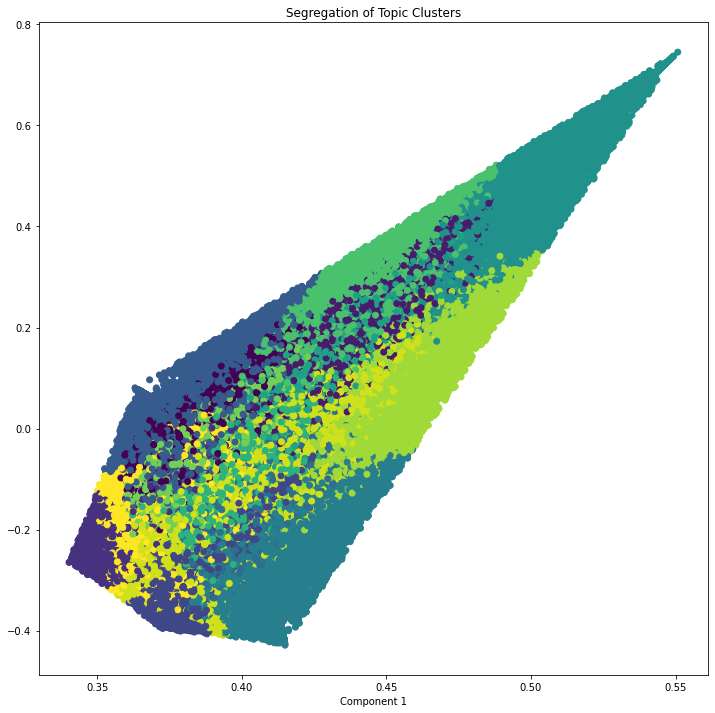

In [22]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's d

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       1.465019 -47.625065       1        1  21.305516
4      54.854797 -36.476795       2        1  19.215547
5      32.212929 -61.444572       3        1  15.914799
2       5.111096 -14.110332       4        1  15.264404
1      26.350170 -33.374702       5        1  15.184010
3      38.109818  -7.222781       6        1  13.115723, topic_info=      Term          Freq         Total Category  logprob  loglift
717   ワクチン  11155.000000  11155.000000  Default  30.0000  30.0000
2575    感染   9254.000000   9254.000000  Default  29.0000  29.0000
2761    接種   9214.000000   9214.000000  Default  28.0000  28.0000
1592    医療   7912.000000   7912.000000  Default  27.0000  27.0000
359    コロナ  11617.000000  11617.000000  Default  26.0000  26.0000
...    ...           ...           ...      ...      ...      ...
3678    発生   1979.415836   5542.067481   Topic6  -5.3110   1.0018
1363    公表   1502.876416   3032.626557   Topic6  -5.5865   1.3293
4151   菅総理   1436.562644   3079.832772   Topic6  -5.6316   1.2687
1151    作業   1275.288743   1675.370162   Topic6  -5.7507   1.7585
1158    使用   1299.731168   2769.455311   Topic6  -5.7317   1.2749

[353 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         2  0.998973     5g
11        6  0.998819    co2
31        2  0.999551   goto
58        3  0.999442  pcr検査
109       6  0.999334    お手元
...     ...       ...    ...
4908      2  0.003696     韓国
4908      5  0.996123     韓国
4946      2  0.999480     食料
4952      3  0.999586    飲食店
4978      1  0.999015     高校

[584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 6, 3, 2, 4])

In [6]:
# Install followed from https://github.com/dex314/GuidedLDA_WorkAround
from lda import guidedlda as glda

In [88]:
all = pd.read_sql_query(f'''SELECT * FROM speech WHERE speaker = 'あべ俊子' ''', conn)
print(len(all))
vectorizer = CountVectorizer(min_df = 5, max_features= 500, stop_words=stop_words)
data_vectorized = vectorizer.fit_transform(all["speech"])
lda_model = LatentDirichletAllocation(n_components=4,
                            random_state=123,
                            learning_method='online',
                            n_jobs = -1)
lda_output = lda_model.fit_transform(data_vectorized)

785


In [89]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ayakowatanabe/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/ayako

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  36.592646
2        1.782994 -295.079681       2        1  28.031086
1      220.811432 -343.832123       3        1  18.945860
3       50.533993  -76.050934       4        1  16.430407, topic_info=     Term       Freq      Total Category  logprob  loglift
476   配偶者  82.000000  82.000000  Default  30.0000  30.0000
376  社会保障  73.000000  73.000000  Default  29.0000  29.0000
248    手当  70.000000  70.000000  Default  28.0000  28.0000
262    採決  44.000000  44.000000  Default  27.0000  27.0000
251    承認  40.000000  40.000000  Default  26.0000  26.0000
..    ...        ...        ...      ...      ...      ...
322    機関  13.503236  19.286902   Topic4  -4.5366   1.4495
259    拡大  15.468953  24.651092   Topic4  -4.4007   1.3401
467    運営  10.061501  13.160828   Topic4  -4.8308   1.5375
158    国際  12.509379  20.349592   Topic4  -4.6131   1.3195
190    安全  13.302876  23.470784   Topic4  -4.5516   1.2383

[227 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         2  0.064785  oecd
0         4  0.906997  oecd
1         3  0.867174   tpp
1         4  0.108397   tpp
3         1  0.349943   あり方
...     ...       ...   ...
496       1  0.994897    高校
498       2  0.916026    高齢
499       1  0.659033   高齢者
499       2  0.305980   高齢者
499       3  0.023537   高齢者

[337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])